<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/tf_Face_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this task we will detect faces in the wild using single shot detector (SSD) models. The SSD model is a bit complicated but will build a simple implmenetation that works for the current task. Basically, the SSD model is a basic model for object detection that uses full evaluation of the given image without using region proposals which was introduced in R-CNN. This makes SSD much faster. The basic architecture is using a CNN to extract the features and at the end we extract volumes of predictions in the shape $[w, h, c + 4]$ where $(w,h)$ is the size of prediction volume and the $c+5$ is the prediction of classes plus the bounding box offsets. Note that we add 1 for the background. Hence the size of the prediction module for one scale is $w \times h (c + 5)$. Note that we predict these valume at different scales and we use matching with IoU to infer the spatial location of the predicted boxes 

![alt text](https://vitalab.github.io/deep-learning/images/ssd_model.png)

# Download The Dataset

We use the dataset fromt his [project](http://vis-www.cs.umass.edu/fddb/). Each single frame frame is annotated by an ellpesioid around the faces that exist in that frame.  This data set contains the annotations for 5171 faces in a set of 2845 images taken from the  [Faces in the Wild data set](http://tamaraberg.com/faceDataset/index.html). Here is a sample ![alt text](http://vis-www.cs.umass.edu/fddb/samples/2002_07_31_big_img_636.jpg)





In [0]:
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
!tar -xzvf originalPics.tar.gz >> tmp.txt
!tar -xzvf FDDB-folds.tgz >> tmp.txt

--2019-02-23 18:16:31--  http://tamaraberg.com/faceDataset/originalPics.tar.gz
Resolving tamaraberg.com (tamaraberg.com)... 54.221.205.183
Connecting to tamaraberg.com (tamaraberg.com)|54.221.205.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579061091 (552M) [application/x-gzip]
Saving to: ‘originalPics.tar.gz’

originalPics.tar.gz 100%[===================>] 552.24M  7.54MB/s    in 80s     

2019-02-23 18:17:51 (6.94 MB/s) - ‘originalPics.tar.gz’ saved [579061091/579061091]

--2019-02-23 18:17:53--  http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160724 (157K) [application/x-gzip]
Saving to: ‘FDDB-folds.tgz’

FDDB-folds.tgz      100%[===================>] 156.96K   159KB/s    in 1.0s    

2019-02-23 18:17:55 (159 KB/s) - ‘FDDB-folds.tgz’ sav

# Extract the Bounding Boxes 

For each image we convert the ellipsoid annotation to a rectangluar region that frames the faces in the current image. Before that we need to explain the concept of anchor boxes. An **anchor box** that exists in a certain region of an image is a box that is responsible for predicting the box in that certain region. Given a certain set of boxes we could match these boxes to the corrospondant anchor box using the intersection over union metric IoU.

![alt text](https://cdn-images-1.medium.com/fit/t/1600/480/1*ntDmAV-hak6IqfxY2DtWiQ.png)

In the above example we see the anchor boxes with the associated true labels. If a certain anchor box has a maximum IoU overlap we consider that anchorbox responsible for that prediction. For simplicity we construct volumes of anchor boxes at only one scale. 

In [0]:
from PIL import Image  
import pickle
import os
import numpy as np
import cv2
import glob

Use anchors of size $(4,4)$

In [0]:
ANCHOR_SIZE = 4

In [0]:
def iou(boxA, boxB):
  #evaluate the intersection points 
  xA = np.maximum(boxA[0], boxB[0])
  yA = np.maximum(boxA[1], boxB[1])
  xB = np.minimum(boxA[2], boxB[2])
  yB = np.minimum(boxA[3], boxB[3])

  # compute the area of intersection rectangle
  interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

  #compute the union 
  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return interArea / unionArea

#for a given box we predict the corrosponding bounding box 
def get_anchor(box):

  max_iou = 0.0 
  
  matching_anchor  = [0, 0, 0, 0]
  matching_index   = (0, 0)
  i = 0 
  j = 0 
  
  w , h = (1/ANCHOR_SIZE, 1/ANCHOR_SIZE)
  
  for x in np.linspace(0, 1, ANCHOR_SIZE +1)[:-1]:
    j = 0 
    for y in np.linspace(0, 1, ANCHOR_SIZE +1)[:-1]:
      xmin = x 
      ymin = y
      
      xmax = (x + w) 
      ymax = (y + h) 
      
      anchor_box = [xmin, ymin, xmax, ymax]
      curr_iou = iou(box, anchor_box)
      
      #choose the location with the highest overlap 
      if curr_iou > max_iou:
        matching_anchor = anchor_box
        max_iou = curr_iou
        matching_index = (i, j)
      j += 1
    i+= 1
  return matching_anchor, matching_index

For each image we output a volume of boxes where we map each true label to the corrosponindg location in the $(4, 4, 5)$ tenosr. Note that here we have only two lables 1 for face and 0 for background so we can use binary cross entropy

In [0]:
def create_volume(boxes):
  output = np.zeros((ANCHOR_SIZE, ANCHOR_SIZE, 5))
  for box in boxes:
    if max(box) == 0:
      continue
    _, (i, j) = get_anchor(box)
    output[i,j, :] = [1] + box
  return output

In [0]:
#read all the files for annotation 
annot_files = glob.glob('FDDB-folds/*ellipseList.txt')
data = {}
for file in annot_files:  
  with open(file, 'r') as f:
    rows = f.readlines()
    
  j = len(rows)
  i = 0   
  while(i < j):
    #get the file name
    file_name = rows[i].replace('\n', '')+'.jpg'
    
    #get the number of boxes 
    num_boxes = int(rows[i+1])
    boxes = []
    
    img = Image.open(file_name)
    w, h = img.size
    #get all the bounding boxes
    for k in range(1, num_boxes+1):
      box = rows[i+1+k]
      box = box.split(' ')[0:5]
      box = [float(x) for x in box]
      
      #convert ellipse to a box 
      xmin = int(box[3]- box[1])
      ymin = int(box[4]- box[0])
      xmax = int(xmin + box[1]*2)
      ymax = int(ymin + box[0]*2)
      boxes.append([xmin/w, ymin/h, xmax/w, ymax/h])
    #conver the boxes to a volume of fixed size 
    data[file_name] = create_volume(boxes)
    i = i + num_boxes+2

# Imports

We use tensorflow with eager execution. Hence, eager execution allows immediate evaluation of tensors without instintiating graph. 

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()

#Create A Dataset

Here we use `tf.data` for manipulating the data and use them for training

In [0]:
def parse_training(filename, label):
  
  image = tf.image.decode_jpeg(tf.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
    
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  
  label = tf.cast(label, tf.float32)
  return image, label

def parse_testing(filename, label):
  
  image = tf.image.decode_jpeg(tf.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  image = tf.image.resize_images(image, [IMG_SIZE, IMG_SIZE])
  
  label = tf.cast(label, tf.float32)
  return image, label

def create_dataset(ff, ll, training = True):

  dataset = tf.data.Dataset.from_tensor_slices((ff, ll)).shuffle(len(ff) - 1)
  if training:
    dataset = dataset.map(parse_training, num_parallel_calls = 4)
  else:
    dataset = dataset.map(parse_testing, num_parallel_calls = 4)
  dataset = dataset.batch(BATCH_SIZE)
  
  return dataset

# Data Split

We create a 10% split for the test data to be used for validation 

In [0]:
files = list(data.keys())
labels = list(data.values())

N = len(files)
M = int(0.9 * N)

#split files for images 
train_files = files[:M]
test_files  = files[M:]

#split labels
train_labels = labels[:M]
test_labels =  labels[M:]

In [0]:
print('training', len(train_files))
print('testing' , len(test_files))

training 2560
testing 285


In [0]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_dataset = create_dataset(train_files, train_labels)
test_dataset = create_dataset(test_files, test_labels, training = False)

# Visualization 

In [0]:
def plot_annot(img, boxes):  

  img = img.numpy()
  boxes = boxes.numpy() 
  
  for i in range(0, ANCHOR_SIZE):
    for j in range(0, ANCHOR_SIZE):
      box = boxes[i, j, 1:] * IMG_SIZE
      label = boxes[i, j, 0]
      
      if np.max(box) > 0:
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (1, 0, 0), 1)

  plt.axis('off')
  plt.imshow(img)
  plt.show()

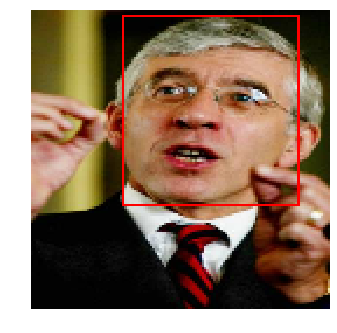

In [0]:
for x, y in train_dataset:
  plot_annot(x[0], y[0])
  break

# Create a model 

We use a ResNet model with multiple blocks and at the end we use a conv volume with size (4, 4, 5) as a preciction.



In [0]:
def conv_block(fs, x, activation = 'relu'):
  conv  = Conv2D(fs, (3, 3), padding = 'same', activation = activation)(x)
  bnrm  = BatchNormalization()(conv)
  drop  = Dropout(0.5)(bnrm)
  return drop

def residual_block(fs, x):
  y = conv_block(fs, x)
  y = conv_block(fs, y)
  y = conv_block(fs, y)
  return Concatenate(axis = -1)([x, y])

In [0]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))

block1 = residual_block(16, inp)
pool1  = MaxPooling2D(pool_size = (2, 2))(block1)
block2 = residual_block(32, pool1)
pool2  = MaxPooling2D(pool_size = (2, 2))(block2)
block3 = residual_block(64, pool2)
pool3  = MaxPooling2D(pool_size = (2, 2))(block3)
block4 = residual_block(128, pool3)
pool4  = MaxPooling2D(pool_size = (2, 2))(block4)
block5 = residual_block(256, pool4)
pool5  = MaxPooling2D(pool_size = (2, 2))(block5)
out  = Conv2D(5, (3, 3), padding = 'same', activation = 'sigmoid')(pool5)

#create a model with one input and two outputs 
model = tf.keras.models.Model(inputs = inp, outputs = out)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

# Loss and gradient 

In [0]:
def loss(pred, y):
  
  #extract the boxes that have values (i.e discard boxes that are zeros)
  mask = y[...,0]
  boxA    = tf.boolean_mask(y, mask)
  boxB    = tf.boolean_mask(pred, mask)
  
  prediction_error = tf.keras.losses.binary_crossentropy(y[...,0], pred[...,0])

  detection_error = tf.losses.absolute_difference(boxA[...,1:], boxB[...,1:]) 
  
  
  return tf.reduce_mean(prediction_error) + 10*detection_error
           
def grad(model, x, y):
  #record the gradient
  with tf.GradientTape() as tape:
    pred = model(x)
    value = loss(pred, y)
  #return the gradient of the loss function with respect to the model variables 
  return tape.gradient(value, model.trainable_variables)

optimizer = tf.train.AdamOptimizer()

# Evaluation metric 

In [0]:
epochs = 20

#initialize the history to record the metrics 
train_loss_history = tfe.metrics.Mean('train_loss')

test_loss_history = tfe.metrics.Mean('test_loss')

best_loss = 1.0 

In [0]:
for i in range(1, epochs + 1):
  
  for x, y in train_dataset:
    pred = model(x)
    grads = grad(model, x, y)

    #update the paramters of the model 
    optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step = tf.train.get_or_create_global_step())

    #record the metrics of the current batch 
    loss_value = loss(pred, y)
    
    #calcualte the metrics of the current batch
    train_loss_history(loss_value)
    
  #loop over the test dataset 
  for x, y in test_dataset:
    pred = model(x)
    
    #calcualte the metrics of the current batch 
    loss_value = loss(pred, y)
    
    #record the values of the metrics 
    test_loss_history(loss_value)
        
  #print out the results 
  print("epoch: [{0:d}/{1:d}], Train: [loss: {2:0.4f}], Test: [loss: {3:0.4f}]".
       format(i, epochs, train_loss_history.result(), 
              test_loss_history.result()))
  
  current_loss = test_loss_history.result().numpy()
  
  #save the best model 
  if current_loss  < best_loss:
    best_loss = current_loss
    print('saving best model with loss ', current_loss)
    model.save('keras.h5')
    
  #clear the history after each epoch 
  train_loss_history.init_variables()
  test_loss_history.init_variables()


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
epoch: [1/20], Train: [loss: 1.3135], Test: [loss: 1.0770]
epoch: [2/20], Train: [loss: 1.0531], Test: [loss: 1.0111]
epoch: [3/20], Train: [loss: 0.9757], Test: [loss: 0.9898]
saving best model with loss  0.9897719687885709
epoch: [4/20], Train: [loss: 0.9287], Test: [loss: 0.9088]
saving best model with loss  0.9088274439175924
epoch: [5/20], Train: [loss: 0.8821], Test: [loss: 0.8573]
saving best model with loss  0.8573145005438063
epoch: [6/20], Train: [loss: 0.8339], Test: [loss: 0.8336]
saving best model with loss  0.8336078458362155
epoch: [7/20], Train: [loss: 0.7658], Test: [loss: 0.7873]
saving best model with loss  0.7873067789607577
epoch: [8/20], Train: [loss: 0.7145], Test: [loss: 0.7429]
saving best model with loss  0.742923272980584
epoch: [9/20], Train: [loss: 0.6688], Test: [loss: 0.7338]
saving best model with loss  0.7337682445844015
epoch: [10/20], Train: [loss: 0.6365],

In [0]:
from tensorflow.keras.models import load_model
best_model = load_model('keras.h5')

# Visualization 

In [0]:
#visualize the predicted bounding box
def plot_pred(img_id):
  font = cv2.FONT_HERSHEY_SIMPLEX

  raw = cv2.imread(img_id)[:,:,::-1]
  
  h, w = (512, 512)
  
  img = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype('float32')
  img = np.expand_dims(img, 0)/255. 
  
  boxes = best_model(img).numpy()[0]

  raw = cv2.resize(raw, (w, h))
    
  for i in range(0, ANCHOR_SIZE):
    for j in range(0, ANCHOR_SIZE):
      box = boxes[i, j, 1:] * w
      lbl = round(boxes[i, j, 0], 2)
      if lbl > 0.5:
        color = [random.randint(0, 255) for _ in range(0, 3)]
        raw = cv2.rectangle(raw, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 3) 
        raw = cv2.rectangle(raw, (int(box[0]), int(box[1])-30), (int(box[0])+70, int(box[1])), color, cv2.FILLED)
        raw = cv2.putText(raw, str(lbl), (int(box[0]), int(box[1])), font, 1, (255, 255, 255), 2)
        

  plt.axis('off')
  plt.imshow(raw)
  plt.show()

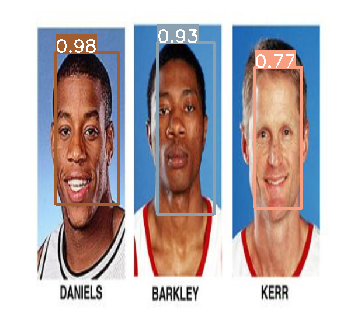

In [0]:
img_id = np.random.choice(test_files)
plot_pred(img_id)

In [0]:
!wget https://pmctvline2.files.wordpress.com/2018/08/friends-revival-jennifer-aniston.jpg -O test.jpg

--2019-02-23 18:47:18--  https://pmctvline2.files.wordpress.com/2018/08/friends-revival-jennifer-aniston.jpg
Resolving pmctvline2.files.wordpress.com (pmctvline2.files.wordpress.com)... 192.0.72.26, 192.0.72.27
Connecting to pmctvline2.files.wordpress.com (pmctvline2.files.wordpress.com)|192.0.72.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319844 (312K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 312.35K   319KB/s    in 1.0s    

2019-02-23 18:47:20 (319 KB/s) - ‘test.jpg’ saved [319844/319844]



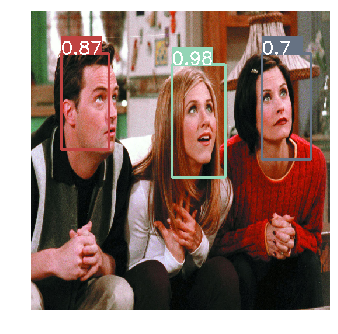

In [0]:
plot_pred('test.jpg')